# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import pprint
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/var/folders/tf/f9bv6m516pjcr2ytmmh92cw00000gn/T/ipykernel_35251/3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/tf/f9bv6m516pjcr2ytmmh92cw00000gn/T/ipykernel_35251/3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
# print(correlations)

## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
# survey_fields.remove("DBN")

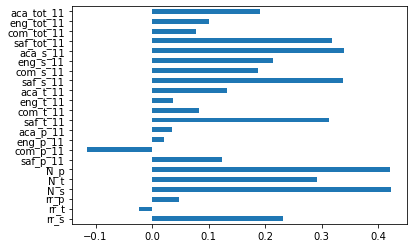

In [11]:
# import plotting library
import matplotlib.pyplot as plt

# Make bar plot for correlations between survey_fields and sat_score
correlations.loc["rr_s":"aca_tot_11"].plot.barh()
plt.show()

### Observations
It looks like the strongest correlations are between the SAT scores and the number of parents or students that respond to the survey. The response rate, on the other hand, is not correlated. This discrepancy might be worth looking at.
<br>
<br>
Additional correlations are between SAT scores and two other factors, the students academic expectations and the perception of safety and respect by students, teachers, and parents. The next two sections look at each.
## SAT Scores & Safety Scores

In [ ]:
# create melted df from combined preserving school borough & DBN, safety scores, and SAT scores
boroughs_long = combined[["boro", "DBN", "sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_columns = ["borough", "DBN", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs_long.columns = boroughs_columns
boroughs_long = boroughs_long.melt(id_vars=["borough", "DBN", "sat_score"])

# scatter plot with borough, SAT scores, and safety scores (0-10)
# plots are for student, teacher, parent, and total safety scores
import seaborn as sns
sns.relplot(data=boroughs_long, x="value", y="sat_score", hue="borough", col="variable", col_wrap=2)
plt.show()

In [ ]:
boroughs_means = combined.groupby("boro").mean()
boroughs_means = boroughs_means[["sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_means.reset_index(inplace=True)
boroughs_columns = ["borough", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs_means.columns = boroughs_columns
print(boroughs_means)

 ### Observations
The scatter plots show two areas influencing the correlation between SAT scores and perceptions of safety and respect. First, the highest SAT scores come from schools with above average perceptions of safety and respect. Second, it looks like most schools have both SAT and safety and respect scores below the median values. It is also interesting that parents have a noticeably higher perception of safety and respect than either teachers or students.
<br>
<br>
Grouping schools by borough and averaging scores paints a different picture. This seems to indicate that SAT scores and perception of safety do not have a strong positive correlation at all. For instance, Staten Island has the highest average SAT scores and Bronx the lowest. However, the student and parent perception of safety and respect scores are higher in the Bronx than in Staten Island. And while Manhattan has mostly the highest safety and respect scores, it ranks in the middle for SAT scores/
 ## SAT Scores & Student Academic Expectations

In [ ]:
# scatter plot with borough, SAT scores, and academic expectations (0-10)
sns.relplot(data=combined, x="aca_s_11", y="sat_score", hue="boro")
plt.show()

### Observations
The academic expectation scatter plot shows similar results to those for perception of safety and respect. Again, there are very few schools in the upper half of the academic expectation scores, and among them about half have better than average SAT scores. Also, we see that most schools have both SAT scores and academic expectations that are below the median value.

## SAT Scores & Demographics on Race/Ethnicity
Taking an objective look at the relationship between race & ethnicity and SAT scores in NYC schools can help in creating an egalitarian public school system that delivers success to all students.

In [ ]:
# Make bar plot for correlations between survey_fields and sat_score
correlations.loc[["asian_per", "black_per", "hispanic_per", "white_per"]].plot.barh()
plt.show()

In [ ]:
# Scatter plot for SAT scores and percent hispanic
sns.relplot(data=combined, x="hispanic_per", y="sat_score", hue="boro")
plt.show()

### Observations
The bar chart for race & ethnicity paints a stark picture, showing a strong negative correlation between SAT scores and the percentage of Hispanic or Black students in the school. That being said, the scatter plot suggests something a little more nuanced.
<br>
<br>
The highest SAT scores (over 1500) occur in schools with a low percentage of Hispanic students, but this is only about 6% of the schools in the data set. Also, there are about 5-10 schools that show close to 100% Hispanic student populations. These schools do have some of the lowest SAT scores, it is important to find out why. Importantly though, it looks like most of the schools show a more even distribution of SAT scores below 1500 while having a percentage of Hispanic students ranging up to about 95%.
<br>
<br>
Additionally, almost all the schools in the Bronx have more than half the student population identifying as Hispanic. There are just a few with less than 40% Hispanic, and two of these schools score the highest SAT averages. 
<br>
<br>
That creates three groups of schools, with one group being divided again in two. The following sections take a look at each.
## Group 1, High SAT scores

In [ ]:
# high_sat
high_sat = combined["Name"][combined["sat_score"] > 1500]
high_sat = high_sat.str.strip()
high_sat_bronx = combined["Name"][(combined["sat_score"] > 1500) & (combined["boro"]=="Bronx")]
display(high_sat)
print(len(high_sat))
print(len(combined))
display(high_sat_bronx)

### Observations
Sure enough, most of these schools sound pretty brainy. The two in the Bronx included.
## Group 2, Student Population Over 95%

In [ ]:
# hispanic_per_95
import numpy as np
columns = combined.iloc[:,[0,1,6,34,8,9,10,60,70]]
hispanic_per_95 = columns[combined["hispanic_per"] > 95]
display(hispanic_per_95)
print(combined["sat_score"].max())
print(combined["sat_score"].min())
# print(np.array_split(range(887,2096), 10))
# [x.tolist() for x in np.array_split(range(10), 3)]
# print([x.tolist() for x in np.array_split(range(887,2096), 3)])

### Observations
This set of schools has the highest percentage of students identifying as Hispanic. The SAT scores all fall within the bottom quartile, with five of them scoring in the lowest tenth all the schools. They are further differentiated by having high percentages of students where English is a second language. The exception to this is the Washington Heights Expeditionary Learning School. All of the schools show a good percentage of passing scores on AP Exams.

Some people would consider AP Exam pass rate as a proxy for academic achievement. This combined with the large number of ELL students suggests that these SAT scores may be non-representational for some groups of NYC public school students.
## Group 3, The Majority of the Schools

In [ ]:
# majority
majority = combined[(combined["sat_score"] < 1500) & (combined["hispanic_per"] < 95)]
sns.relplot(data=majority, x="hispanic_per", y="sat_score", hue="boro")
plt.show()

In [ ]:
majority_correlations = majority.corr()
majority_correlations = majority_correlations["sat_score"]
# print(correlations)
# Make bar plot for correlations between survey_fields and sat_score
majority_correlations.loc[["asian_per", "black_per", "hispanic_per", "white_per"]].plot.barh()
plt.show()

### Observations
Removing the schools with the highest percentage of Hispanic students (this includes many international and ELL students) and the schools with SAT scores over 1500 shows a more uniform distribution of SAT scores. The correlation between SAT scores and percentage of students identifying as Hispanic drops to less than -0.2.